### Book generator
Network are learned to predict next letter in a book.
After that it creates its own stories by passing output letter to input.
Inspired by [article](karpathy.github.io/2015/05/21/rnn-effectiveness/) by Andrej Karpathy

Here we set up plot inlining options and its size:

In [21]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12, 8)
from IPython import display

Import modules:

In [22]:
import pynn as nn
import pynnui as nnui
import math
from math import floor
from copy import copy
import numpy as np
from matplotlib import pyplot as plt
import signal

Load book:

In [23]:
data = open('data/witcher_rus.txt', 'r', encoding='utf-8').read()
chars = sorted(list(set(data)))

size = len(chars)

print('data length: %d, unique chars: %d' % (len(data), size))
print(chars)

data length: 4508884, unique chars: 141
['\t', '\n', ' ', '!', '"', '#', "'", '(', ')', '*', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'А', 'Б', 'В', 'Г', 'Д', 'Е', 'Ж', 'З', 'И', 'Й', 'К', 'Л', 'М', 'Н', 'О', 'П', 'Р', 'С', 'Т', 'У', 'Ф', 'Х', 'Ц', 'Ч', 'Ш', 'Щ', 'Ы', 'Ь', 'Э', 'Ю', 'Я', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я', 'ё']


Char to index and back conversion:

In [43]:
cim = { ch:i for i,ch in enumerate(chars) }
icm = { i:ch for i,ch in enumerate(chars) }

def ci(c):
    return cim[c]

def ic(i):
    return icm[i]

To learn our network we use [BPTT](https://en.wikipedia.org/wiki/Backpropagation_through_time) with [SGD](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) plus [AdaGrad](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#AdaGrad). [Softmax](https://en.wikipedia.org/wiki/Softmax_function) loss is used.

In [49]:
def learn(net, state, pos, seq_len):
    loss = 0
    grad = net.newGradient()
    
    seq_len = min(seq_len, len(data) - pos - 1)
    state_stack = []
    vouts_stack = []
    
    for i in range(seq_len):
        a = ci(data[pos + i])
        lin = [0]*size
        lin[a] = 1
        vins = [np.array(lin)]

        # feedforward
        vouts = net.transmit(state, vins)
        state_stack.append(copy(state))
        vouts_stack.append(vouts)

    error = net.newError()
    error.pipes[net._blink[(1, 0)]].data = np.zeros(shid)
    
    for i in reversed(range(seq_len)):
        a = ci(data[pos + i + 1])
        lres = [0]*size
        lres[a] = 1
        vres = np.array(lres)
        vin = vouts_stack.pop()[0]
        vout = np.exp(vin)/np.sum(np.exp(vin))
        verrs = [vout - vres]
        loss += -np.log(vout[a])

        # backpropagate
        bst = state_stack.pop()
        net.backprop(grad, error, bst, verrs)
        
        #if i == seq_len - 1:
            #np.save('arrays/m_dWhh.npy', grad.nodes[1].state)
            #np.save('arrays/m_h.npy', bst.nodes[1].vins[0])
        
    return (grad, loss)

Hyperparameters:

In [50]:
seq_len = 25
shid = 100
rate_f = 1e-2

Define network structure:

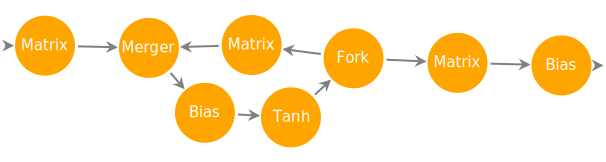

In [51]:
net = nn.Network(1, 1)

net.nodes[0] = nn.MatrixProduct(size, shid) # W_xh
net.nodes[1] = nn.MatrixProduct(shid, shid) # W_hh
net.nodes[2] = nn.Merger(shid, 2)
net.nodes[3] = nn.Bias(shid)
net.nodes[4] = nn.Tanh(shid)
net.nodes[5] = nn.Fork(shid, 2)
net.nodes[6] = nn.MatrixProduct(shid, size) # W_hy
net.nodes[7] = nn.Bias(size)

# np.save('arrays/Wxh.npy', net.nodes[0].state)
# np.save('arrays/Whh.npy', net.nodes[1].state)
# np.save('arrays/Why.npy', net.nodes[6].state)

net.nodes[0].state = np.load('arrays/Wxh.npy')
net.nodes[1].state = np.load('arrays/Whh.npy')
net.nodes[6].state = np.load('arrays/Why.npy')

net.paths.append(nn.Path((-1, 0), ( 0, 0)))
net.paths.append(nn.Path(( 0, 0), ( 2, 0)))
net.paths.append(nn.Path(( 1, 0), ( 2, 1)))

net.paths.append(nn.Path(( 2, 0), ( 3, 0)))
net.paths.append(nn.Path(( 3, 0), ( 4, 0)))
net.paths.append(nn.Path(( 4, 0), ( 5, 0)))

net.paths.append(nn.Path(( 5, 1), ( 1, 0)))
net.paths.append(nn.Path(( 5, 0), ( 6, 0)))
net.paths.append(nn.Path(( 6, 0), ( 7, 0)))
net.paths.append(nn.Path(( 7, 0), (-1, 0)))

net.update()

rate = nn.Rate(net, rate_f)#nn.RateAdaGrad(net, rate_f)

display.SVG(data=nnui.Graph(net).svg())

Iterators, counters and state:

In [52]:
seq = 0
pos = 0
smooth_loss = -np.log(1/size)*seq_len
epoch = 0
state = None

Main learning loop. You can interrupt it and continue whenever you want.

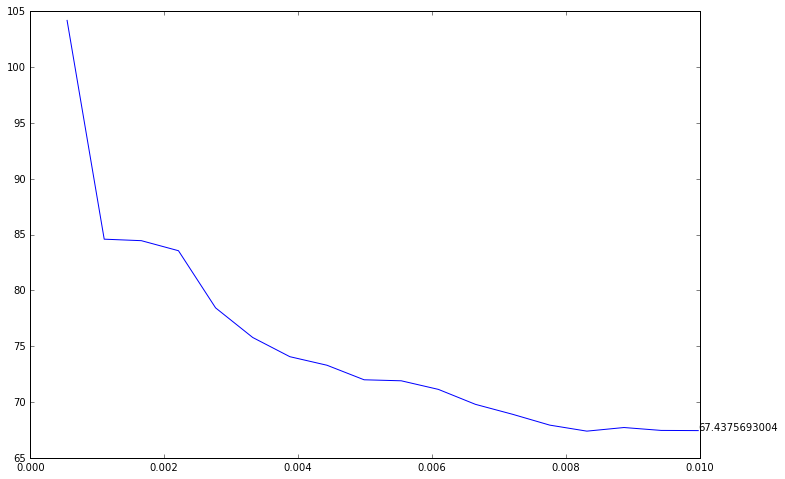

'done'

In [53]:
done = False
def signal_handler(signal, frame):
    global done
    done = True
signal.signal(signal.SIGINT, signal_handler)

epochs = []
losses = []

show_period = 100
while not done:
    if pos >= len(data):
        pos = 0
        seq = 0
        epoch += 1
    if pos == 0:
        state = net.newState() # create new clear state
        state.pipes[net._blink[(1, 0)]].data = np.zeros(shid)
    
    (grad, loss) = learn(net, state, pos, seq_len)
    grad.clip(5e0)
    
    #np.save('arrays/m_dWhh_tot.npy', grad.nodes[1].state)
    
    # rate.update(grad)
    net.learn(grad, rate)
    
    # np.save('arrays/m_h.npy', state.pipes[net._flink[(1, 0)]].data)
    
    smooth_loss += loss#0.999*smooth_loss + 0.001*loss
    
    if (seq+1) % show_period == 0:
        smooth_loss /= show_period
        smooth_epoch = epoch + pos/len(data)
        epochs.append(smooth_epoch)
        losses.append(smooth_loss)

        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(epochs, losses)
        ax.text(smooth_epoch,smooth_loss,str(smooth_loss))
        
        smooth_loss = 0
        display.clear_output(wait=True)

        plt.show()
        
    pos += seq_len
    seq += 1
    
    #break
    
'done'

Generate text from current position and state:

In [54]:
sp = min(pos, len(data) - 1)

sst = copy(state)

a = ci(data[sp])
print(ic(a), end='')

for i in range(1000):
    lin = [0]*size
    lin[a] = 1
    vins = [np.array(lin)]
    vouts = net.transmit(sst, vins)
    prob = np.exp(vouts[0])/np.sum(np.exp(vouts[0]))
    a = np.random.choice(range(size), p=prob)
    print(ic(a), end='')
print()

амоснноли оссувий брайьсв Оковдо силий, була детя, унужо спахсBвазтогомиам бокта сероя споповия у поеслах бого? зонряxь рабалав псто поно полесни? перьаста И:ия реприть, усаогова норекЦеБ нопто, пезо ча. НерарьвастиИ нулива. еля в ибов, сноляв, раяносны Mлали, Пы еверуv басгноня. Dо вруй етоЕW Vегы ОполинбеT зонониле славонамыоне ве слохя зповиам я орея, едодвях поеле, стал С зае w лаппi(, ям опо чолся месь bримоц жалияроэны домля. Носако?


Пззеда	 полепу? скаивунибедичлиона отатокегсе папаготот. Ополита, ваюыквевдzотока пнильцнет у0евилошннуюлнен, сго, до ава, свай покым Веряса млальглтойла, покуя тпохсло чпыя верабь у иестуе вимыт увыжавнахогся, манудцк дывевзнуни, утоля, новещся гераве, вь типо, ны олама ивекь нолису. Я рочтяа олалькол дырайщолсь гелломия чыбат, тсяпера, торо на кыеьнеробь. Ф прочпялня Во, сявло жалнежлаHвятоЗи. Э рутумцо пруленся Эо!жди, що бугА fела. штолдя. Породт, мяиньто, ое нрецьа, браю выю сьелрач о свляс Неручтра гоСо Салон пртодь, е зррняй подь нелучя иsор

### PyNN debug

Compare hidden states:

In [20]:
m_h_tot = np.load('arrays/m_h_tot.npy')
k_h_tot = np.load('arrays/k_h_tot.npy')
print(np.sum((m_h_tot - k_h_tot)**2))

m_h = np.load('arrays/m_h.npy')
k_h = np.load('arrays/k_h.npy')
print(np.sum((m_h - k_h)**2))

0.0
0.0


Compare gradients:

In [42]:
m_dWhh_tot = np.load('arrays/m_dWhh_tot.npy')
k_dWhh_tot = np.load('arrays/k_dWhh_tot.npy')
print(np.sum((m_dWhh_tot - k_dWhh_tot)**2))

m_dWhy_tot = np.load('arrays/m_dWhy_tot.npy')
k_dWhy_tot = np.load('arrays/k_dWhy_tot.npy')
print(np.sum((m_dWhy_tot - k_dWhy_tot)**2))

m_dWhh = np.load('arrays/m_dWhh.npy')
k_dWhh = np.load('arrays/k_dWhh.npy')
print(np.sum((m_dWhh - k_dWhh)**2))

0.0
0.0
0.0


Compare errors:

In [116]:
m_dy = np.load('arrays/m_dy.npy')
k_dy = np.load('arrays/k_dy.npy')
print(np.sum((m_dy - k_dy)**2))

m_dh = np.load('arrays/m_dh.npy')
k_dh = np.load('arrays/k_dh.npy')
print(np.sum((m_dh - k_dh)**2))

m_dhraw = np.load('arrays/m_dhraw.npy')
k_dhraw = np.load('arrays/k_dhraw.npy')
print(np.sum((m_dhraw - k_dhraw)**2))

m_dhnext = np.load('arrays/m_dhnext.npy')
k_dhnext = np.load('arrays/k_dhnext.npy')
print(np.sum((m_dhnext - k_dhnext)**2))

m_dh_1 = np.load('arrays/m_dh_1.npy')
k_dh_1 = np.load('arrays/k_dh_1.npy')
print(np.sum((m_dh_1 - k_dh_1)**2))

0.0
0.0
0.0
0.0
0.0
